In [2]:
!pip install arch

     ---------------------------------------- 0.0/927.1 kB ? eta -:--:--
     ------------- ------------------------ 317.4/927.1 kB 9.9 MB/s eta 0:00:01
     ---------------------------- --------- 686.1/927.1 kB 8.7 MB/s eta 0:00:01
     -------------------------------------- 927.1/927.1 kB 7.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\Aryan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

plt.style.use("seaborn-v0_8")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


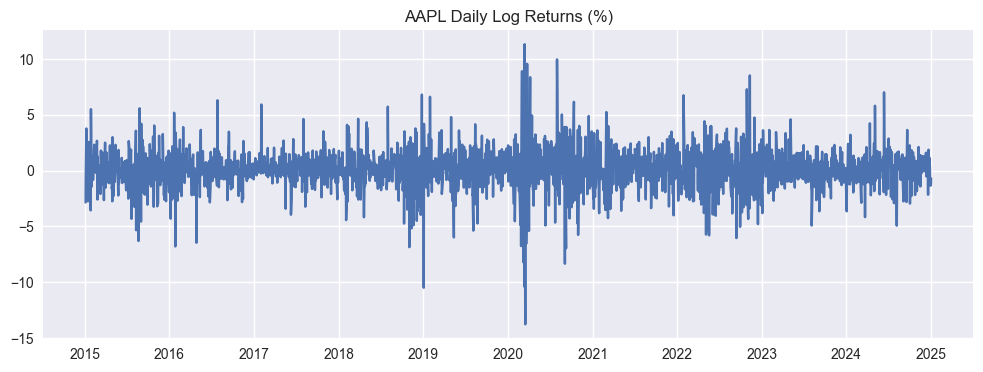

In [5]:
data = yf.download("AAPL", start="2015-01-01", end="2025-01-01")["Close"]
returns = 100 * np.log(data / data.shift(1)).dropna()  # % log returns

plt.figure(figsize=(12,4))
plt.plot(returns)
plt.title("AAPL Daily Log Returns (%)")
plt.show()

In [6]:
adf_stat, pval, _, _, crit_vals, _ = adfuller(returns)
print("ADF Test Statistic:", adf_stat)
print("p-value:", pval)
print("Critical Values:", crit_vals)


ADF Test Statistic: -15.549457424929743
p-value: 2.109147267852538e-28
Critical Values: {'1%': -3.432962135264372, '5%': -2.862694028699462, '10%': -2.567384333962417}


In [7]:
from statsmodels.stats.diagnostic import het_arch
lm_stat, lm_pval, f_stat, f_pval = het_arch(returns)
print("ARCH LM Test p-value:", lm_pval)

ARCH LM Test p-value: 1.1746107754973917e-79


In [8]:
# Fit ARCH(1) ----------------------------------------------------
arch_model_fit = arch_model(returns, vol="ARCH", p=1).fit(disp="off")
print(arch_model_fit.summary())

#  Fit GARCH(1,1) -------------------------------------------------
garch_model_fit = arch_model(returns, vol="GARCH", p=1, q=1).fit(disp="off")
print(garch_model_fit.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4946.65
Distribution:                  Normal   AIC:                           9899.30
Method:            Maximum Likelihood   BIC:                           9916.79
                                        No. Observations:                 2515
Date:                Sat, Aug 16 2025   Df Residuals:                     2514
Time:                        15:11:18   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1350  3.580e-02      3.771  1.625e-04 [6.484e-0

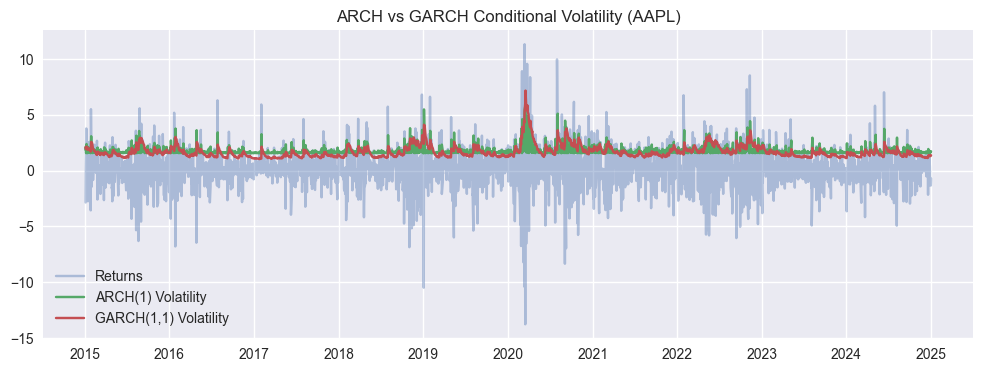

In [9]:
plt.figure(figsize=(12,4))
plt.plot(returns.index, returns, label="Returns", alpha=0.4)
plt.plot(arch_model_fit.conditional_volatility, label="ARCH(1) Volatility")
plt.plot(garch_model_fit.conditional_volatility, label="GARCH(1,1) Volatility")
plt.legend()
plt.title("ARCH vs GARCH Conditional Volatility (AAPL)")
plt.show()

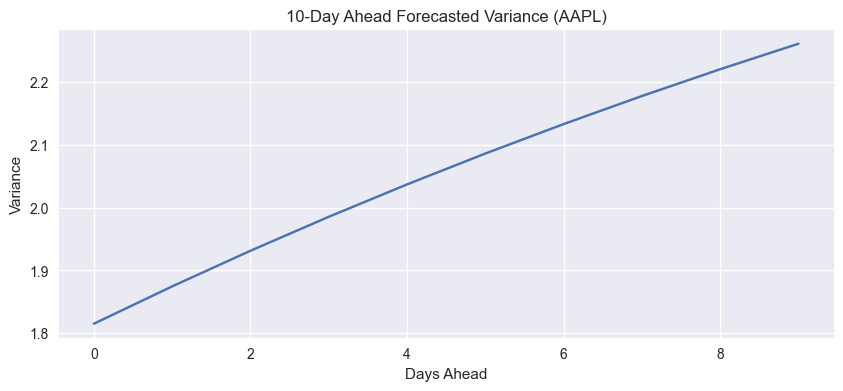

In [14]:
forecast = garch_model_fit.forecast(horizon=10)
plt.figure(figsize=(10,4))
plt.plot(forecast.variance[-1:].T.values)
plt.title("10-Day Ahead Forecasted Variance (AAPL)")
plt.xlabel("Days Ahead")
plt.ylabel("Variance")
plt.show()

In [11]:
mean_forecast = garch_model_fit.forecast(horizon=1).mean["h.1"].iloc[-1]
var_forecast = garch_model_fit.forecast(horizon=1).variance["h.1"].iloc[-1]
vol_forecast = np.sqrt(var_forecast)

VaR_95 = mean_forecast - 1.65 * vol_forecast
print(f"1-Day 95% Value-at-Risk: {VaR_95:.2f}%")

1-Day 95% Value-at-Risk: -2.07%
